In [1]:
import os

os.chdir("../../../..")

os.getcwd()

'c:\\Users\\mquick\\Documents\\zeitgeist blog\\projects\\geopolitical_proximity'

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from utils.types.variables import pct_military_spending, size_nuclear_arsenal
from utils.world_bank import WBDataHandler
from utils.tools import add_col_combinations
from utils.impute import Imputer
from google.cloud.bigquery import Client
from settings import PROJECT
from bq.bq_tables import nodes, node_data

### % of global military spending

In [3]:
mil_exp_code = "MS.MIL.XPND.CD"

In [4]:
mil_exp_handler = WBDataHandler(variable=pct_military_spending)

In [5]:
mil_df = mil_exp_handler.get_data(indicator_code=mil_exp_code, from_year=1977, to_year=2023)

In [6]:
wld_df = mil_df.loc[mil_df["countryiso3code"]=="WLD", ["date", "value"]].rename(columns={"value":"total"})

In [7]:
mil_df = mil_df.merge(wld_df, on=["date"], how="left")

In [8]:
nodes_mil_df = mil_exp_handler.keep_nodes_only(mil_df)

In [9]:
nodes_mil_df.loc[nodes_mil_df["value"]==0, "value"] = np.nan # strange cases where reported spending is 0, e.g. Russia in 1992

In [10]:
nodes_mil_df["value_pct"] = (nodes_mil_df["value"] / nodes_mil_df["total"]) * 100

In [11]:
imputer = Imputer(group_by_col="iso3")

In [12]:
mil_missing = imputer.pct_completeness_by_group(dataframe=nodes_mil_df, value_col="value_pct")

In [13]:
len(mil_missing[mil_missing["complete_pct"]<1])

193

In [14]:
interpolated_mil_df = imputer.interpolate_values(dataframe=nodes_mil_df)

In [15]:
interpolated_mil_df["value_pct_carried"] = imputer.carry_values(
    dataframe=interpolated_mil_df,
    value_col="value_pct",
    max_consec=5,
    forwards=True,
    backwards=True
)

In [16]:
interpolated_mil_df["value_pct_extrapol"] = imputer.extrapolate_values(dataframe=interpolated_mil_df,
                                                                       x_col="date",
                                                                       y_col="value_pct_carried",
                                                                       floor=0,
                                                                       ceiling=100
                                                                       )

In [17]:
mil_missing = imputer.pct_completeness_by_group(dataframe=interpolated_mil_df, value_col="value_pct_extrapol")

In [18]:
mil_missing["complete_pct"].unique()

array([1., 0.])

In [19]:
mil_missing[mil_missing["complete_pct"]==0]

,iso3,complete_pct
3,AND,0.0
7,ATG,0.0
18,BHS,0.0
24,BRB,0.0
26,BTN,0.0
38,COM,0.0
40,CRI,0.0
46,DMA,0.0
59,FSM,0.0
69,GRD,0.0


In [20]:
interpolated_mil_df["value_pct_extrapol"] = interpolated_mil_df["value_pct_extrapol"].fillna(0)

<Axes: xlabel='date', ylabel='value_pct_extrapol'>

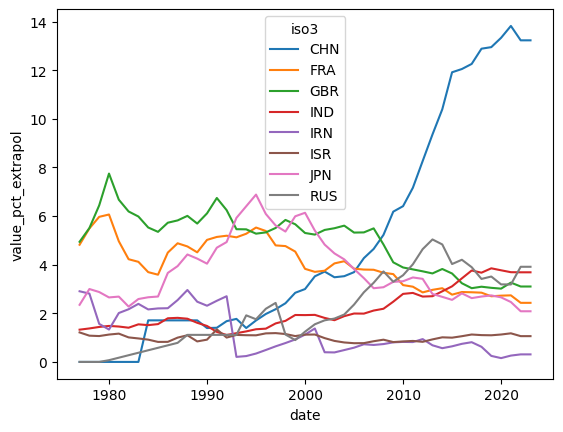

In [21]:
sns.lineplot(data=interpolated_mil_df[interpolated_mil_df["iso3"].isin(["CHN", "FRA", "GBR", "IND", "IRN", "RUS", "JPN", "ISR"])],
             x="date", y="value_pct_extrapol", hue="iso3"
             ) # extrapolation producing strange estimates for China due to later meteoric increase

In [22]:
chn_pre_extrapol = interpolated_mil_df.loc[(interpolated_mil_df["date"]==1984) & (interpolated_mil_df["iso3"]=="CHN"), "value_pct_extrapol"].item()
chn_pre_extrapol

1.7095279595032855

In [23]:
interpolated_mil_df.loc[(interpolated_mil_df["date"]<1984) & (interpolated_mil_df["iso3"]=="CHN"), "value_pct_extrapol"] = chn_pre_extrapol

In [24]:
interpolated_mil_df["value_norm"] = mil_exp_handler.normalise_values(dataframe=interpolated_mil_df,
                                                                     group_by_col="date",
                                                                     raw_values_col="value_pct_extrapol",
                                                                     apply_log=True
                                                                     )

<Axes: xlabel='date', ylabel='value_norm'>

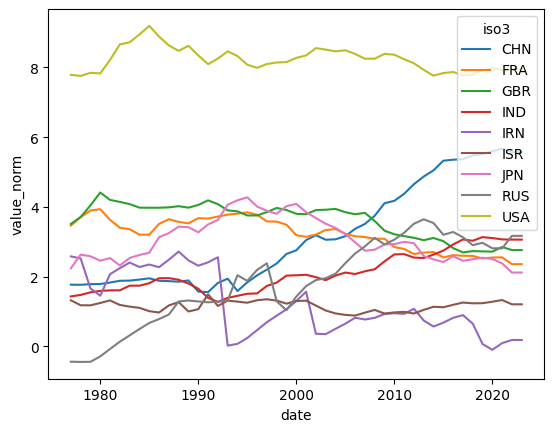

In [25]:
sns.lineplot(data=interpolated_mil_df[interpolated_mil_df["iso3"].isin(["USA", "CHN", "FRA", "GBR", "IND", "IRN", "RUS", "JPN", "ISR"])],
             x="date", y="value_norm", hue="iso3"
             )

In [26]:
interpolated_mil_df = interpolated_mil_df.drop("value", axis=1).rename(columns={"value_pct_extrapol":"value"})

In [27]:
upload_mil_df = mil_exp_handler.format_df_for_upload(dataframe=interpolated_mil_df)

In [28]:
# mil_exp_handler.upload_to_bq(dataframe=upload_mil_df)

True

### Size of nuclear arsenal

[Source](https://ourworldindata.org/nuclear-weapons)

In [29]:
nukes = pd.read_csv("./notebooks/nodes/data/nuclear_arsenal.csv")

In [30]:
nukes.head(3)

,Entity,Code,Year,Number of nuclear warheads
0,China,CHN,1945,0
1,China,CHN,1946,0
2,China,CHN,1947,0


In [31]:
bq = Client(PROJECT)

In [32]:
job = bq.query(f"SELECT id AS node_id, iso3 FROM `{nodes.id}`")
nodes_df = job.result().to_dataframe()

In [33]:
nukes = nukes\
    .merge(nodes_df, left_on="Code", right_on="iso3", how="right")\
    .drop(["Entity", "Code"], axis=1)\
    .rename(columns={"Number of nuclear warheads":"value"})

In [34]:
nukes["Year"] = nukes["Year"].fillna(2023)

In [35]:
nukes_all_combos = add_col_combinations(dataframe=nukes.drop("node_id", axis=1), index_cols=["Year", "iso3"])

In [36]:
nukes_all_combos = nukes_all_combos\
    .merge(nukes[["node_id", "iso3"]].drop_duplicates(), on="iso3", how="left")\
    .sort_values(["iso3", "Year"])\
    .fillna(0)

In [37]:
node_data.schema

[SchemaField('node_id', 'INT64', 'REQUIRED', None, None, (), None),
 SchemaField('variable_id', 'INT64', 'REQUIRED', None, None, (), None),
 SchemaField('value', 'FLOAT64', 'NULLABLE', None, None, (), None),
 SchemaField('value_norm', 'FLOAT64', 'NULLABLE', None, None, (), None),
 SchemaField('is_imputed', 'BOOL', 'REQUIRED', None, None, (), None),
 SchemaField('is_latest', 'BOOL', 'REQUIRED', None, None, (), None),
 SchemaField('date_added', 'DATETIME', 'REQUIRED', None, None, (), None),
 SchemaField('year', 'INT64', 'NULLABLE', None, None, (), None)]

In [38]:
nukes_all_combos = nukes_all_combos\
    .rename(columns={"Year":"year"})\
    .assign(
        variable_id = size_nuclear_arsenal.id,
        is_imputed = False,
        date_added = datetime.now()
    )

In [39]:
nukes_all_combos.loc[nukes_all_combos["year"]==2023, "is_latest"] = True
nukes_all_combos["is_latest"] = nukes_all_combos["is_latest"].fillna(False)

In [40]:
nukes_all_combos["value_norm"] = nukes_all_combos["value"].apply(np.log1p)

<Axes: xlabel='year', ylabel='value_norm'>

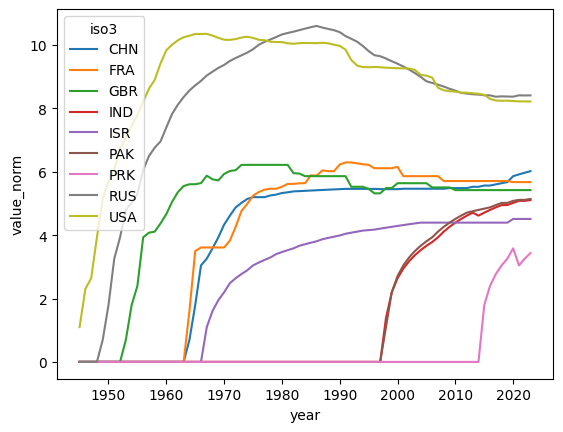

In [41]:
sns.lineplot(data=nukes_all_combos[nukes_all_combos["iso3"].isin(["USA", "RUS", "CHN", "GBR", "IND", "FRA", "ISR", "PAK", "PRK"])],
             x="year", y="value_norm", hue="iso3"
             )

In [42]:
nukes_all_combos.drop("iso3", axis=1, inplace=True)

In [43]:
nukes_handler = WBDataHandler(size_nuclear_arsenal)

In [44]:
# nukes_handler.upload_to_bq(nukes_all_combos)

True